# Normative vs. alternative permutations


In [3]:
import pandas as pd
import seaborn as sns
import sys
sys.path.append('../..')
from data_import import*
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
from helper import*
from plot_params import*
from paths import*

In [4]:
paths = paths()
pp = PlotParams()

In [5]:
f4_path = paths.f4_path+ 'NOGTHSH/'
fig_save_path = paths.plot_save_path + 'permuted_phi/'
GT_223_225 = 'NOGTHSH_ACROSS_SESSIONS_GT_train_on_223_225.csv'
perm_phi = 'NOGTHSH_LEARNING_CURVES_D8_D9_permute_alter_sequences3_23_09_14.csv'

## Read the data

In [6]:
D9GT_tag, D9GT = import_and_transform_data(f4_path, GT_223_225)
#print (D9GT_tag)

In [7]:
permuted_phi_tag, permuted_phi = import_and_transform_data(f4_path, perm_phi)
#print (permuted_phi_tag)

In [8]:
#########################
### Drop RTs aboove 3 std. 
D9GT = drop_RTs_above_3std_below_180(D9GT)
permuted_phi = drop_RTs_above_3std_below_180(permuted_phi)

In [9]:
def get_rsqr_values(data, phi_seq = True):
    
    if phi_seq == True:
        groupby = ['model', 'participant', 'phi_seq', 'block']
        droplevel_num = 'level_4'
    else:
        groupby = ['model', 'participant', 'block']
        droplevel_num = 'level_3'
    
    corr_matrix = (data.groupby(groupby)
               [['rt', 'rt_predicted']]
               .corr()
              )
    corr_matrix.reset_index(inplace = True)
    corr_matrix.drop([droplevel_num, 'rt'], axis = 1, inplace = True)
    matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
    matrix['r_sqr'] = matrix.rt_predicted**2
    matrix.drop('rt_predicted', axis = 1, inplace = True)
    return (matrix)

In [10]:
permuted_phi.loc[permuted_phi['ini'].str.contains('alt1'), 'phi_seq'] = 'alt1'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt2'), 'phi_seq'] = 'alt2'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt3'), 'phi_seq'] = 'alt3'
permuted_phi.loc[permuted_phi['ini'].str.contains('alt4'), 'phi_seq'] = 'alt4'
permuted_phi.loc[permuted_phi['ini'].str.contains('D9_seq'), 'phi_seq'] = 'D9-seq'
permuted_phi.loc[permuted_phi['ini'].isin(['saw', 'scissors', 'camino', 'silkroad']), 'phi_seq'] = 'D8-seq'
permuted_phi_rsqr = get_rsqr_values(permuted_phi, phi_seq = True)

In [11]:
D9GT_rsqr = get_rsqr_values(D9GT, phi_seq=False)
D9GT_rsqr = D9GT_rsqr.loc[D9GT_rsqr['block']> 200]
D9GT_rsqr['phi_seq'] = 'D9GT'

## Concat the two frames



In [12]:
permuted_phi_rsqr2 = pd.concat([D9GT_rsqr, permuted_phi_rsqr], ignore_index=True, sort=False)
permuted_phi_rsqr2.drop('model', axis=1, inplace=True)

# Normative vs. alter permutations

In [13]:
permuted_phi_rsqr5 = permuted_phi_rsqr.loc[~(permuted_phi_rsqr['phi_seq'].isin(['D8-seq', 'D9-seq']))]
permuted_phi_rsqr5 = permuted_phi_rsqr5.set_index(['participant', 'block'])
permuted_phi_rsqr5.drop('model', axis = 1, inplace=True)

In [14]:
sequences = sorted(list(set([item for item in permuted_phi_rsqr5.phi_seq])))
sequences

['alt1', 'alt2', 'alt3', 'alt4']

In [15]:
D9CT_data = permuted_phi_rsqr.loc[permuted_phi_rsqr['phi_seq'] == 'D9-seq']
D9CT_data = D9CT_data.set_index(['participant', 'block'])[['r_sqr']]
D9CT_data.rename(columns = {'r_sqr': 'D9CT_rsqr'}, inplace=True)

In [16]:
merged_frames = []
for seqs in sequences:
    df = permuted_phi_rsqr5.loc[permuted_phi_rsqr5['phi_seq']== seqs]
    merged = pd.merge(df, D9CT_data, left_index=True, right_index=True)
    merged_frames.append(merged)

In [17]:
permuted_phi_rsqr6 = pd.concat(merged_frames)
permuted_phi_rsqr6.rename(columns = {'r_sqr': 'alt_seq_rsqr'}, inplace = True)

In [18]:
permuted_phi_rsqr6.reset_index(inplace = True)
permuted_phi_rsqr6 = permuted_phi_rsqr6.groupby(['participant', 'phi_seq']).mean()
permuted_phi_rsqr6.reset_index(inplace=True)
permuted_phi_rsqr6.drop('phi_seq', axis = 1, inplace=True)
averaged_over_alterseqs = permuted_phi_rsqr6.groupby(['participant']).mean()

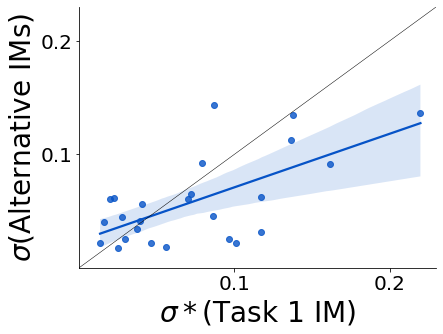

In [19]:
fig, axs = plt.subplots(figsize = pp.figsize, facecolor = 'white')


sns_plot = sns.regplot(data=averaged_over_alterseqs, 
                       x = 'D9CT_rsqr', y = 'alt_seq_rsqr', color = pp.basic_color)



sns_plot.set_xlim(0, 0.23)
sns_plot.set_ylim(0, 0.23)
sns_plot = sns.lineplot(x = [0,0.25],y= [0, 0.25], color = 'black', linewidth = 0.5)
sns_plot.set_yticks([0.1, 0.2])
sns_plot.set_yticklabels([0.1, 0.2], fontsize = pp.ticklabsize)
sns_plot.set_xticks([0.1, 0.2])
sns_plot.set_xticklabels([0.1, 0.2], fontsize =  pp.ticklabsize)
sns.despine()


sns_plot.set_ylabel(r'$\sigma$(Alternative IMs)', fontsize = pp.axlabsize)
sns_plot.set_xlabel(r'$\sigma*$(Task 1 IM)', fontsize = pp.axlabsize);

In [20]:
fig.savefig(paths.plot_save_path + 'manuscript_plots_standard/' +'alternative_permutations.pdf', bbox_inches='tight')
fig.savefig(paths.plot_save_path + 'manuscript_plots_standard/' +'alternative_permutationse.png', bbox_inches='tight')

# T test to compare the normative and the alternative permutations

In [21]:
permuted_phi_rsqr2.phi_seq.unique()

array(['D9GT', 'D8-seq', 'D9-seq', 'alt1', 'alt2', 'alt3', 'alt4'],
      dtype=object)

In [22]:
permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'D9-seq', 'perm_type'] = 'sigma_d8'
permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt1', 'perm_type'] = 'alt'
permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt2', 'perm_type'] = 'alt'
permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt3', 'perm_type'] = 'alt'
permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt4', 'perm_type'] = 'alt'

In [23]:
print(permuted_phi_rsqr2['perm_type'].value_counts())
print(permuted_phi_rsqr2['perm_type'].isnull().sum())

perm_type
alt         2500
nan         1175
sigma_d8     625
Name: count, dtype: int64
0


In [24]:
normative_permutation = permuted_phi_rsqr2.loc[permuted_phi_rsqr2['perm_type'] == 'sigma_d8'].r_sqr
alternative_permutations = permuted_phi_rsqr2.loc[permuted_phi_rsqr2['perm_type'] == 'alt'].r_sqr

In [25]:
res = sp.stats.ttest_ind(normative_permutation, alternative_permutations, alternative = 'greater')
print(f'Independent samples t-test t-value {res.statistic:.3f}, p value: {res.pvalue:.3f}{get_stars(res.pvalue)}, df: {res.df:.0f}')

Independent samples t-test t-value 5.098, p value: 0.000***, df: 3123


## Mean, std

In [31]:
mean = normative_permutation.mean()
std = normative_permutation.std()
print(f'Normative permutation mean: {mean:.3f}, std: {std:.3f}')

mean = alternative_permutations.mean()
std = alternative_permutations.std()
print(f'Alternative permutations mean: {mean:.3f}, std: {std:.3f}')

Normative permutation mean: 0.074, std: 0.074
Alternative permutations mean: 0.059, std: 0.066


## ANOVA for the 5 permutations - on the non-averaged datapoints

In [25]:
f_value, p_value = sp.stats.f_oneway(permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'D9-seq'].r_sqr,
                                     permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt1'].r_sqr,
                                     permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt2'].r_sqr,
                                     permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt3'].r_sqr, 
                                     permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt4'].r_sqr)
print(f'Anova f-value {f_value:.3f}, p value: {p_value:.3f}{get_stars(p_value)}')

Anova f-value 7.495, p value: 0.000***


## Post hoc test

In [26]:
control = permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'D9-seq'].r_sqr

In [27]:
dunett = sp.stats.dunnett(permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt1'].r_sqr,
                 permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt2'].r_sqr,
                 permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt3'].r_sqr,
                 permuted_phi_rsqr2.loc[permuted_phi_rsqr2['phi_seq'] == 'alt4'].r_sqr,
                 control=control, alternative='two-sided', random_state=None)

In [28]:
pvalue = [str('%.3f'% item)+get_stars(item) for item in list(dunett.pvalue)]
Dunett_statistics = pd.DataFrame({'statistics':dunett.statistic, 'pvalue':pvalue})
Dunett_statistics

,statistics,pvalue
0,-4.812367,0.000***
1,-4.107752,0.000***
2,-4.310865,0.000***
3,-2.891581,0.014*
